# Figure S3

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.gridspec as gridspec

import replay_structure.structure_models as models
import replay_structure.metadata as meta
import replay_structure.read_write as read_write
import replay_structure.utils as utils

import importlib

In [2]:
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [11]:
ratday_data = dict()
ripple_data = dict()
run_snippet_data_9ms = dict()
run_snippet_data_60ms = dict()
ripple_trajectories = dict()
for session in meta.Session_List:
    ratday_data[str(session)] = read_write.load_ratday_data(session)
    ripple_data[str(session)] =  read_write.load_spikemat_data(
        session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name)
    run_snippet_data_9ms[str(session)] = read_write.load_spikemat_data(
        session, 9, meta.Run_Snippet_Data.name)
    run_snippet_data_60ms[str(session)] = read_write.load_spikemat_data(session, 60, meta.Run_Snippet_Data.name)
    ripple_trajectories[str(session)] = read_write.load_trajectory_results(
        session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)

loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ratday/rat1day1_4cm.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ripples/rat1day1_4cm_3ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/run_snippets/rat1day1_4cm_9ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/run_snippets/rat1day1_4cm_60ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_trajectories.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ratday/rat1day2_4cm.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ripples/rat1day2_4cm_3ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/run_snippets/rat1day2_4cm_9ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/run_snippets/rat1day2_4cm_60ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/r

In [12]:
def select_run_periods(ratday, run_period_threshold_s=2):
    run_lengths = (
        ratday.velocity_info["run_ends"] - ratday.velocity_info["run_starts"]
    )
    run_periods_use = run_lengths > run_period_threshold_s
    run_starts = ratday.velocity_info["run_starts"][run_periods_use]
    run_ends = ratday.velocity_info["run_ends"][run_periods_use]
    return np.vstack((run_starts, run_ends)).T

run_period_trajectories_cm = dict()
for session in meta.Session_List:
    run_times_s = select_run_periods(ratday_data[str(session)])
    run_period_trajectories_cm[str(session)] = utils.get_trajectories(
            ratday_data[str(session)], run_times_s
        )

In [13]:
def find_best_fit_line(run_mean_frs, ripple_mean_frs):
    fit = np.linalg.lstsq(run_mean_frs[:,None], ripple_mean_frs)
    return fit[0]

def find_best_fit_line_alldata(movement_avg_fr_dict, swr_avg_fr_dict):
    all_movement = np.array([0])
    all_swr = np.array([0])
    for i in range(len(movement_avg_fr_dict)):
        all_movement = np.append(all_movement, movement_avg_fr_dict[i])
        all_swr = np.append(all_swr, swr_avg_fr_dict[i])
    return find_best_fit_line(all_movement, all_swr)

run_mean_frs = dict()
ripple_mean_frs = dict()
slope_best_fit = np.zeros((meta.N_SESSIONS))
for i, session in enumerate(meta.Session_List):
    run_mean_frs[i] = ratday_data[str(session)].place_field_data["mean_firing_rate_array"][ratday_data[str(session)].place_field_data["place_cell_ids"]]
    ripple_mean_frs[i] = ripple_data[str(session)].ripple_info["popburst_mean_firing_rate_array"]
    slope_best_fit[i] = find_best_fit_line(run_mean_frs[i], ripple_mean_frs[i])
    
slope_best_fit_all_data = find_best_fit_line_alldata(run_mean_frs, ripple_mean_frs)

<ipython-input-13-194c268c3eef>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit = np.linalg.lstsq(run_mean_frs[:,None], ripple_mean_frs)


In [14]:
def get_total_spikes_vec(spikemats):
    n_traj = len(spikemats)
    total_spikes_vec = np.full(n_traj, np.nan)
    for i in range(n_traj):
        if spikemats[i] is not None:
            total_spikes_vec[i] = spikemats[i].sum()
    return total_spikes_vec

def get_total_distance(trajectory):
    return np.sum(np.sqrt(np.sum((trajectory[1:] - trajectory[:-1])**2, axis=1)))

def get_velocity(trajectory, time_window_s):
    distance = get_total_distance(trajectory)
    duration_s = len(trajectory) * time_window_s
    velocity = distance/duration_s
    return velocity

def get_velocity_vec(trajectories, time_window_s):
    n_traj = len(trajectories)
    velocity_cm_per_s = np.full(n_traj, np.nan)
    for i in range(n_traj):
        if trajectories[i] is not None:
            velocity_cm_per_s[i] = get_velocity(trajectories[i], time_window_s)
    return velocity_cm_per_s

def get_distance_vec(trajectories):
    n_traj = len(trajectories)
    distance_vec = np.full(n_traj, np.nan)
    for i in range(n_traj):
        if trajectories[i] is not None:
            distance_vec[i] = get_total_distance(trajectories[i])
    return distance_vec[~np.isnan(distance_vec)]

def get_n_time_windows(spikemats):
    n_traj = len(spikemats)
    total_spikes_vec = np.full(n_traj, np.nan)
    for i in range(n_traj):
        if spikemats[i] is not None:
            total_spikes_vec[i] = spikemats[i].shape[0]
    return total_spikes_vec[~np.isnan(total_spikes_vec)]

In [15]:
velocity_ripples = dict()
velocity_run_periods = dict()
mean_velocity_ripples = np.zeros(meta.N_SESSIONS)
mean_velocity_run_periods = np.zeros(meta.N_SESSIONS)
sd_velocity_ripples = np.zeros(meta.N_SESSIONS)
sd_velocity_run_periods = np.zeros(meta.N_SESSIONS)

for i, session in enumerate(meta.Session_List):
    velocity_ripples[str(session)] = get_velocity_vec(ripple_trajectories[str(session)].most_likely_trajectories, .003)
    velocity_run_periods[str(session)] = get_velocity_vec(run_period_trajectories_cm[str(session)], 1/30)
    mean_velocity_ripples[i] = np.nanmean(velocity_ripples[str(session)])
    mean_velocity_run_periods[i] = np.nanmean(velocity_run_periods[str(session)])
    sd_velocity_ripples[i] = np.nanstd(velocity_ripples[str(session)])/np.sqrt(meta.N_SESSIONS)
    sd_velocity_run_periods[i] = np.nanstd(velocity_run_periods[str(session)])/np.sqrt(meta.N_SESSIONS)


In [16]:
distance_ripples = np.array([])
distance_snippets_9ms = np.array([])
distance_snippets_60ms = np.array([])
n_timewindows_ripples = np.array([])
n_timewindows_snippets_9ms = np.array([])
n_timewindows_snippets_60ms = np.array([])
total_spikes_ripples = np.array([])
total_spikes_snippets_9ms = np.array([])
total_spikes_snippets_60ms = np.array([])

for i, session in enumerate(meta.Session_List):
    distance_ripples = np.append(distance_ripples, get_distance_vec(ripple_trajectories[str(session)].most_likely_trajectories))
    distance_snippets_9ms = np.append(distance_snippets_9ms, get_distance_vec(run_snippet_data_9ms[str(session)].run_info["true_trajectories_cm"]))
    distance_snippets_60ms = np.append(distance_snippets_60ms, get_distance_vec(run_snippet_data_60ms[str(session)].run_info["true_trajectories_cm"]))
    n_timewindows_ripples = np.append(n_timewindows_ripples, get_n_time_windows(ripple_data[str(session)].ripple_info["spikemats_popburst"]))
    n_timewindows_snippets_9ms = np.append(n_timewindows_snippets_9ms, get_n_time_windows(run_snippet_data_9ms[str(session)].run_info["spikemats"]))
    n_timewindows_snippets_60ms = np.append(n_timewindows_snippets_60ms, get_n_time_windows(run_snippet_data_60ms[str(session)].run_info["spikemats"]))
    total_spikes_ripples = np.append(total_spikes_ripples, get_total_spikes_vec(ripple_data[str(session)].ripple_info["spikemats_popburst"]))
    total_spikes_snippets_9ms = np.append(total_spikes_snippets_9ms, get_total_spikes_vec(run_snippet_data_9ms[str(session)].run_info["spikemats"]))
    total_spikes_snippets_60ms = np.append(total_spikes_snippets_60ms, get_total_spikes_vec(run_snippet_data_60ms[str(session)].run_info["spikemats"]))

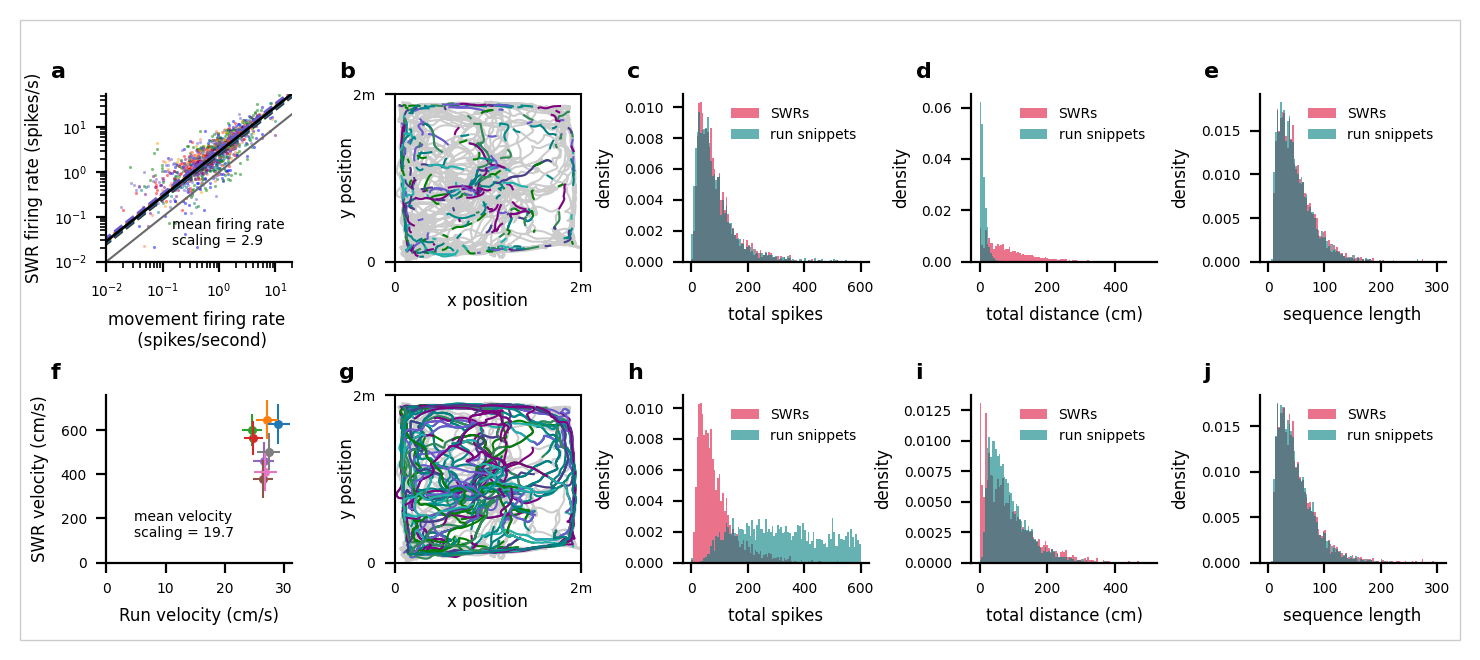

In [17]:
session = meta.Session_List[0]
colors=['teal', 'slateblue', 'purple', 'green', 'darkslateblue', 'seagreen', 'lightseagreen', 'darkcyan']
legend_fontsize=11

fig, ax = plt.subplots(2,5,figsize=(7.2,3.1), dpi=200)
plt.subplots_adjust(left=.06, wspace=.55, hspace=.8, right = .99)

ax[0,1].plot(ratday_data[str(session)].data['pos_xy_cm'][:,0], ratday_data[str(session)].data['pos_xy_cm'][:,1],
          color='gray', alpha=.4, linewidth=.75)
ax[1,1].plot(ratday_data[str(session)].data['pos_xy_cm'][:,0], ratday_data[str(session)].data['pos_xy_cm'][:,1],
          color='gray', alpha=.4, linewidth=.75)

for i in range(len(run_snippet_data_9ms[str(session)].run_info['true_trajectories_cm'])):
    ax[0,1].plot(run_snippet_data_9ms[str(session)].run_info['true_trajectories_cm'][i][:,0], 
            run_snippet_data_9ms[str(session)].run_info['true_trajectories_cm'][i][:,1],
            color=colors[i%len(colors)], linewidth=.75)
    
for i in range(len(run_snippet_data_60ms[str(session)].run_info['true_trajectories_cm'])):
    ax[1,1].plot(run_snippet_data_60ms[str(session)].run_info['true_trajectories_cm'][i][:,0], 
            run_snippet_data_60ms[str(session)].run_info['true_trajectories_cm'][i][:,1],
            color=colors[i%len(colors)], linewidth=.75)
    
# for session in Session_List:
bins=np.linspace(0,600,100)
ax[0,2].hist(total_spikes_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[0,2].hist(total_spikes_snippets_9ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
ax[1,2].hist(total_spikes_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[1,2].hist(total_spikes_snippets_60ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
for i in range(2):
    ax[i,2].set_xlabel('total spikes')
    

bins=np.linspace(0,500,100)
ax[0,3].hist(distance_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[0,3].hist(distance_snippets_9ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
ax[1,3].hist(distance_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[1,3].hist(distance_snippets_60ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
for i in range(2):
    ax[i,3].set_xlabel('total distance (cm)')

bins=np.linspace(0,300,100)
ax[0,4].hist(n_timewindows_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[0,4].hist(n_timewindows_snippets_9ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
ax[1,4].hist(n_timewindows_ripples, alpha=.6, color='crimson', bins=bins, label='SWRs', density=True)
ax[1,4].hist(n_timewindows_snippets_60ms, alpha=.6, color='teal', bins=bins, label='run snippets', density=True)
for i in range(2):
    ax[i,4].set_xlabel('sequence length')

for i in range(meta.N_SESSIONS):
    ax[1,0].scatter(mean_velocity_run_periods[i], mean_velocity_ripples[i], s=5)
    ax[1,0].errorbar(mean_velocity_run_periods[i], mean_velocity_ripples[i], yerr=sd_velocity_ripples[i], xerr=sd_velocity_run_periods[i], linewidth=.75)
ax[1,0].set_xlim(left=0)
ax[1,0].set_ylim(bottom=0)
ax[1,0].set_xlabel("Run velocity (cm/s)")#, fontsize=15)
ax[1,0].set_ylabel("SWR velocity (cm/s)")#, fontsize=15)
ax[1,0].text(.15,.15, f"mean velocity\nscaling = {np.mean(mean_velocity_ripples/mean_velocity_run_periods).round(1)}", 
             size=5, transform=ax[1,0].transAxes)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)


colors = ['blue', 'green', 'red', 'purple', 'orange', 'coral', 'teal', 'slateblue']
plot_lim = 20
for i, session in enumerate(meta.Session_List):
    rd_run_mean_frs = ratday_data[str(session)].place_field_data["mean_firing_rate_array"][ratday_data[str(session)].place_field_data["place_cell_ids"]]
    rd_ripple_mean_frs = ripple_data[str(session)].ripple_info["popburst_mean_firing_rate_array"]
    ax[0,0].scatter(rd_run_mean_frs, rd_ripple_mean_frs, s=5, color=colors[i], alpha=.5, marker='.', linewidths=0)
    ax[0,0].plot(np.arange(plot_lim+1), np.arange(plot_lim+1)*slope_best_fit[i], linestyle='--', color=colors[i], linewidth=1)

ax[0,0].plot(np.arange(plot_lim+1), np.arange(plot_lim+1)*slope_best_fit.mean(), linestyle='-', color='black', label=fr"$\alpha$={slope_best_fit.mean().round(1)}",
        linewidth=1)
ax[0,0].plot([0,plot_lim], [0, plot_lim], color='dimgray', linestyle='-', linewidth=.75, label=fr"$\alpha$=1")
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('movement firing rate \n (spikes/second)')#, fontsize=16)
ax[0,0].set_ylabel('SWR firing rate (spikes/s)')#, fontsize=16)
ax[1,0].text(.35,.1, f"mean firing rate\nscaling = {slope_best_fit.mean().round(1)}", 
             size=5, transform=ax[0,0].transAxes)
ax[0,0].set_ylim([.01, plot_lim*slope_best_fit_all_data])
ax[0,0].set_xlim([.01, plot_lim])
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)


for i in range(2):
    ax[i,1].set_xlim([0,200])
    ax[i,1].set_ylim([0,200])
    ax[i,1].set_xticks([0,200])
    ax[i,1].set_yticks([0,200])
    ax[i,1].set_xticklabels(['0', '2m'])#, fontsize=18)
    ax[i,1].set_yticklabels(['0', '2m'])#, fontsize=18)
    ax[i,1].spines['right'].set_linewidth(.75)
    ax[i,1].spines['left'].set_linewidth(.75)
    ax[i,1].spines['top'].set_linewidth(.75)
    ax[i,1].spines['bottom'].set_linewidth(.75)
    ax[i,1].set_xlabel('x position', labelpad=-1)
    ax[i,1].set_ylabel('y position', labelpad=-1)
# ax.set_title('Randomly Sampled \nbehavior trajectories', fontsize=20)

for i in range(2):
    for j in range(2,5):
        ax[i,j].legend(frameon=False)#, fontsize=legend_fontsize)
        ax[i,j].spines["top"].set_visible(False)
        ax[i,j].spines["right"].set_visible(False)
        ax[i,j].set_ylabel('density')
        ax[i,j].legend(frameon=False, fontsize=5)
    


panel_letters = {
    (0,0): "a", (0,1): "b", (0,2): "c", (0,3): "d", (0,4): "e",
    (1,0): "f", (1,1): "g", (1,2): "h", (1,3): "i", (1,4): "j"}
for i in range(2):
    for j in range(5):
        ax[i,j].text(-.3,1.1, panel_letters[i,j], size=8, transform=ax[i,j].transAxes, fontweight='bold')

plt.savefig(os.path.join(meta.FIGURES_PATH, "FigureS3.svg"), dpi=500, transparent=True)

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0, 0), 1, 1, fill=False, color="k", lw=.5, alpha=.2,
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

plt.show()